# Image Denoising

In this notebook you will see an example of an **image denoising**, using an _autoencoder_, inspired into Francois Chollet [tutorial](https://blog.keras.io/building-autoencoders-in-keras.html).

## Libraries

In [1]:
import keras
from keras import layers
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

## Data

Here, we are using as our data the [MNIST](https://keras.io/api/datasets/mnist/) dataset.

This is a dataset of 60 000 images of size 28 $\times$ 28 grayscale images of hand written of 10 digits (0, 1, 2, 3, 4, 5, 6, 7, 8, 9), along with a test set of 10 000 images.

### Importing data

This dataset is mostly used in _classification problems_, that is why they have the images and a second information, the labels of each image.

But, as we are going to map digits images to clean them, we are not going to use the labels.

In this way, our process is going to take the **noised images** and clear the same based into the **true images** as _targets_.

In [2]:
(x_train, _), (x_test, _) = mnist.load_data()

In [3]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [4]:
dimension = x_train.shape[1]

### Pre-processing data

Because here we are doing a simple example, we will use just a fraction of the complete dataset: just 700 images as _train_ and the same number of images as _test_.

In [5]:
num_data = 700
x_train = x_train[0:num_data]
x_test = x_test[0:num_data]

We are going to normalize the images between 0 and 1 and to reshape them.

In [6]:
norm_factor = 255.
x_train = x_train.astype('float32')/norm_factor
x_test = x_test.astype('float32')/norm_factor
x_train = np.reshape(x_train, (len(x_train), dimension, dimension, 1))
x_test = np.reshape(x_test, (len(x_test), dimension, dimension, 1))

Here, we need to noisy the images, then, we apply a Gaussian noisy matrix and clip the images between 0 and 1.

In [7]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc = 0.0, scale = 1.0, size = x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc = 0.0, scale = 1.0, size = x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

Visualizing some noise images images.

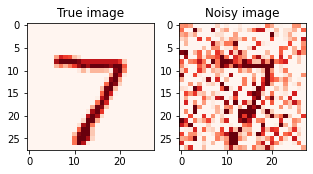

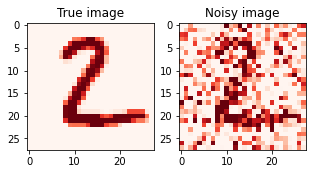

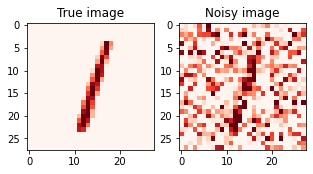

In [8]:
n = 3
for i in range(n):
    fig, axes = plt.subplots(1, 2)
    fig.set_size_inches(5, 5)
    axes[0].set_title('True image')
    im0 = axes[0].imshow(x_test[i].reshape(dimension, dimension), cmap = 'Reds')
    axes[1].set_title('Noisy image')
    im1 = axes[1].imshow(x_test_noisy[i].reshape(dimension, dimension), cmap = 'Reds')

## Building the Autoencoder

Defining the input images for the **autoencoder**.

In [9]:
input_img = keras.Input(shape = (dimension, dimension, 1))

### Encoder

In [10]:
x = layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same')(input_img)
x = layers.MaxPooling2D(pool_size = (2, 2), padding = 'same')(x)
x = layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x)
encoded = layers.MaxPooling2D(pool_size = (2, 2), padding = 'same')(x)

### Decoder

In [11]:
x = layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same')(encoded)
x = layers.UpSampling2D(size = (2, 2))(x)
x = layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x)
x = layers.UpSampling2D(size = (2, 2))(x)
decoded = layers.Conv2D(filters = 1, kernel_size = (3, 3), activation = 'sigmoid', padding = 'same')(x)

### Autoencoder

In [12]:
autoencoder = keras.Model(input_img, decoded)

Visualizing the autoencoder.

In [13]:
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 32)          9248      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 32)       

### Compilation

In [14]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

### Fitting

In [15]:
validation_split = 0.8
history = autoencoder.fit(x_train_noisy, x_train, epochs = 40, batch_size = 20, shuffle = True, validation_split = validation_split)

Epoch 1/40
7/7 [==============================] - 1s 97ms/step - loss: 0.5620 - val_loss: 0.5068
Epoch 2/40
7/7 [==============================] - 1s 75ms/step - loss: 0.4794 - val_loss: 0.4501
Epoch 3/40
7/7 [==============================] - 0s 56ms/step - loss: 0.4302 - val_loss: 0.3964
Epoch 4/40
7/7 [==============================] - 1s 76ms/step - loss: 0.3692 - val_loss: 0.3260
Epoch 5/40
7/7 [==============================] - 0s 69ms/step - loss: 0.2933 - val_loss: 0.2537
Epoch 6/40
7/7 [==============================] - 0s 69ms/step - loss: 0.2365 - val_loss: 0.2276
Epoch 7/40
7/7 [==============================] - 1s 76ms/step - loss: 0.2143 - val_loss: 0.2121
Epoch 8/40
7/7 [==============================] - 0s 58ms/step - loss: 0.2005 - val_loss: 0.2023
Epoch 9/40
7/7 [==============================] - 0s 55ms/step - loss: 0.1931 - val_loss: 0.2012
Epoch 10/40
7/7 [==============================] - 0s 61ms/step - loss: 0.1872 - val_loss: 0.1875
Epoch 11/40
7/7 [============

### Tracking the history of the training stage

In [16]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

In [17]:
train_loss = history.history['loss']
train_val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

Visualizing the history of the training.

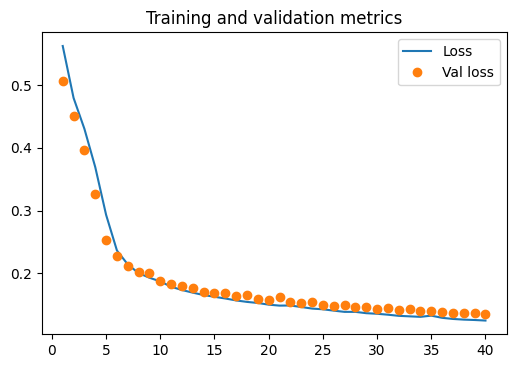

In [18]:
plt.figure(dpi = 100)
plt.plot(epochs, train_loss, label = 'Loss')
plt.plot(epochs, train_val_loss, 'o', label = 'Val loss')
plt.title('Training and validation metrics')
plt.legend()
plt.savefig('history.png')

### Prediction

In [19]:
all_denoised_images = autoencoder.predict(x_test_noisy)

### Evaluation

In [20]:
test_loss  = autoencoder.evaluate(x_test_noisy, x_test, batch_size = 20)
test_loss

35/35 [==============================] - 0s 9ms/step - loss: 0.1354


0.13541769981384277

# Visual results

Here, we can compare our visual results looking side by side the noisy, targets and denoised  images.

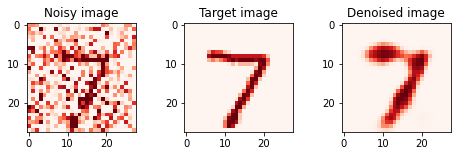

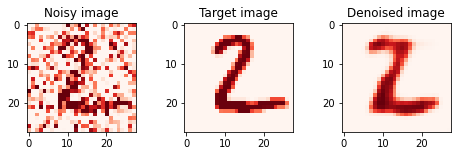

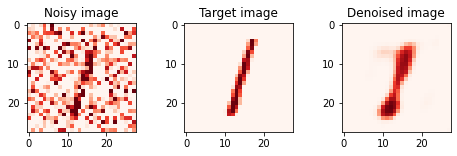

In [22]:
n = 3
for i in range(n):
    fig, axes = plt.subplots(1, 3)
    fig.set_size_inches(8, 2)
    axes[0].set_title('Noisy image')
    im0 = axes[0].imshow(x_test_noisy[i].reshape(dimension, dimension), cmap = 'Reds')
    axes[1].set_title('Target image')
    im1 = axes[1].imshow(x_test[i].reshape(dimension, dimension), cmap = 'Reds')
    axes[2].set_title('Denoised image')
    im2 = axes[2].imshow(all_denoised_images[i].reshape(dimension, dimension), cmap = 'Reds')
    plt.savefig(f'comparison-{i}.png')